In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import models, layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
np.random.seed(97)
plt.style.use('fivethirtyeight')

# dataset path
path = '/content/drive/My Drive/Assignment/text-classification/'

In [2]:
data = pd.read_csv(path + 'dataset.csv', usecols=['Text', 'Polarity'], encoding='utf-8')
data.head()

,Text,Polarity
0,প্রকৃতি প্রেমী মানুষটি তার দোকানের নাম দিয়েছে...,Positive
1,নিঃশ্বাস জানান দিচ্ছে বেচে আছি,Neutral
2,আপনাদেদ ভিডিও গুলো দেখে নতুন নতুন অনেক কিছু শে...,Positive
3,আপু আমি বানাইছি অনেক মজা হইছে....,Positive
4,ছোট্ট পরীর আগমনে আমরাও খুব আনন্দিত।,Positive


In [3]:
data['Text'] = data['Text'].astype(str)
data['Polarity'] = data['Polarity'].astype(str)

# Data Pre-processing

In [4]:
data.columns

Index(['Text', 'Polarity'], dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8539 entries, 0 to 8538
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      8539 non-null   object
 1   Polarity  8539 non-null   object
dtypes: object(2)
memory usage: 133.5+ KB


In [6]:
data['Polarity'].value_counts()

Positive        3141
neutral         2996
Negative        2213
Neutral          183
nan                3
evenly_voted       2
negative           1
Name: Polarity, dtype: int64

In [7]:
def proper_polarity(data):
    data.loc[data['Polarity'] == 'neutral', 'Polarity'] = 'Neutral'
    data.loc[data['Polarity'] == 'negative', 'Polarity'] = 'Negative'

In [8]:
proper_polarity(data)

In [9]:
data['Polarity'].value_counts()

Neutral         3179
Positive        3141
Negative        2214
nan                3
evenly_voted       2
Name: Polarity, dtype: int64

In [10]:
data[data['Polarity'] == 'nan'].index.values

array([633, 669, 730])

In [11]:
data.drop(labels=data[data['Polarity'] == 'nan'].index.values, inplace=True)
data.drop(labels=data[data['Polarity'] == 'evenly_voted'].index.values, inplace=True)

In [12]:
data['Polarity'].value_counts()

Neutral     3179
Positive    3141
Negative    2214
Name: Polarity, dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8534 entries, 0 to 8538
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      8534 non-null   object
 1   Polarity  8534 non-null   object
dtypes: object(2)
memory usage: 200.0+ KB


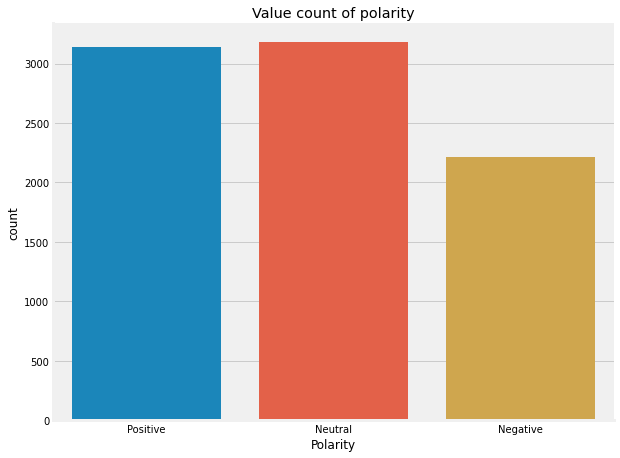

In [14]:
_ = sns.catplot(
    x='Polarity', data=data, kind='count', height=6, aspect=11.7/8.27
).set(title="Value count of polarity")

In [15]:
def clean_data(text):
    text = text.lower()
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoji, '', text)
    text = re.sub('[.:(){},@?''\d+]', '', str(text))
    return text

In [16]:
data['cleaned'] = data['Text'].apply(clean_data)

In [17]:
data.loc[6928]

Text        @ রাজিবফেসবুক, অনলাইন ছেড়ে রাস্তায় নামুন
Polarity                                     Neutral
cleaned        রাজিবফেসবুক অনলাইন ছেড়ে রাস্তায় নামুন
Name: 6928, dtype: object

In [18]:
print("Original: ", data['Text'][20], '\nCleaned: ', data['cleaned'][20])

Original:  পৃথিবী কি দ্বিতীয় বৃহত্তম গ্রহ??? 
Cleaned:  পৃথিবী কি দ্বিতীয় বৃহত্তম গ্রহ


In [19]:
print("Original: ", data['Text'][318], '\nCleaned: ', data['cleaned'][318])

Original:  গোলের যাদুকর রোনাল্ডোকে অভিনন্দন💝 
Cleaned:  গোলের যাদুকর রোনাল্ডোকে অভিনন্দন


# Explore data

In [20]:
df = data['cleaned'].apply(lambda x: len(x.split()))

In [21]:
df1 = data.loc[df < 2]

In [22]:
df1.tail(4)

,Text,Polarity,cleaned
8113,আবার,Neutral,আবার
8119,একমত,Neutral,একমত
8131,হাস্যকর,Neutral,হাস্যকর
8132,ভাল,Neutral,ভাল


In [23]:
data.loc[5324]

Text        শোভাযাত্রা
Polarity      Positive
cleaned     শোভাযাত্রা
Name: 5324, dtype: object

## Remove row with length less than 2

In [24]:
data['length'] = data['cleaned'].apply(lambda x: len(x.split()))
dataset = data.loc[data.length > 2]
dataset = dataset.reset_index(drop=True)
print("After Cleaning:","\nRemoved {} Sentences that were less than 2 word".format(len(data)-len(dataset)),
      "\nTotal Sentences:",len(dataset))

After Cleaning: 
Removed 122 Sentences that were less than 2 word 
Total Sentences: 8412


In [25]:
dataset.loc[20]

Text        পৃথিবী কি দ্বিতীয় বৃহত্তম গ্রহ???
Polarity                               Neutral
cleaned        পৃথিবী কি দ্বিতীয় বৃহত্তম গ্রহ
length                                       5
Name: 20, dtype: object

# Dataset Analysis

In [26]:
def data_summary(dataset):
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Polarity.value_counts().to_dict().items()]
    
    # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.Polarity==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0) + 1
        
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1], reverse = True)
        
        # Documents per class
        documents.append(len(list(dataset[dataset.Polarity==label].cleaned)))
        
        # Total Word per class
        words.append(len(word_list))
        
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name:", label)
        print("Number of Documents: {}".format(len(list(dataset[dataset.Polarity==label].cleaned))))  
        print("Number of Words: {}".format(len(word_list))) 
        print("Number of Unique Words: {}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k, v in ordered[:10]:
              print("{}\t{}".format(k, v))
    print("Total Number of Unique Words: {}".format(len(np.unique(total_u_words))))           
   
    return documents, words, u_words, class_label

documents, words, u_words, class_names = data_summary(dataset)


Class Name: Positive
Number of Documents: 3118
Number of Words: 25450
Number of Unique Words: 7682
Most Frequent Words:

অনেক	227
ভালো	215
করে	194
জন্য	191
ভাল	174
এই	166
আমার	163
হবে	151
না	148
আমি	147

Class Name: Neutral
Number of Documents: 3102
Number of Words: 27764
Number of Unique Words: 8992
Most Frequent Words:

না	424
কি	302
করে	246
এই	205
আর	179
হবে	178
জন্য	168
করা	148
আমি	145
হয়	145

Class Name: Negative
Number of Documents: 2192
Number of Words: 20741
Number of Unique Words: 7282
Most Frequent Words:

না	484
এই	179
করে	174
আর	172
কোন	109
হবে	108
নাই	105
কি	102
মানুষ	100
জন্য	95
Total Number of Unique Words: 17776


## Summary visualization

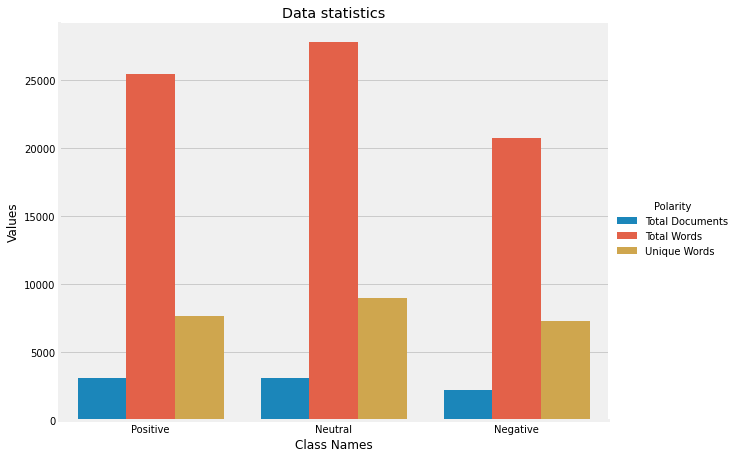

In [27]:
data_matrix = pd.DataFrame({'Total Documents': documents,
                            'Total Words': words,
                            'Unique Words': u_words,
                            'Class Names': class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Polarity", value_name="Values")

_ = sns.catplot(
    data=df, x='Class Names', y="Values", hue="Polarity", kind="bar", height=6, aspect=11.7/8.27
).set(title="Data statistics")

## Sentence length distribution

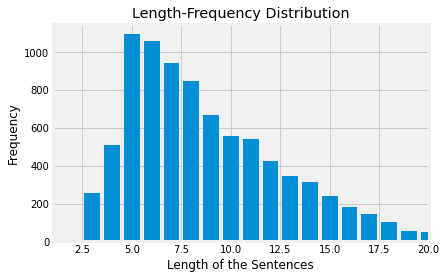


Maximum Length of a Sentence: 32
Minimum Length of a Sentence: 3
Average Length of a Sentence: 9.0


In [28]:
dataset['SentenceLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.SentenceLength:
    frequency[i] = frequency.get(i, 0) + 1

plt.bar(frequency.keys(), frequency.values())
plt.xlim(1, 20)


plt.xlabel('Length of the Sentences')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"\nMaximum Length of a Sentence: {max(dataset.SentenceLength)}")
print(f"Minimum Length of a Sentence: {min(dataset.SentenceLength)}")
print(f"Average Length of a Sentence: {round(np.mean(dataset.SentenceLength), 0)}")

In [29]:
print(dataset.SentenceLength.median())

8.0


# Label Encoding & Dataset split

In [30]:
sample_data = [2000, 5000, 7000, 8000]

In [31]:
def label_encoding(polarity, bool):
    # instantiate label encoder
    le = LabelEncoder()
    
    # fit the encoder
    le.fit(polarity)
    
    # transform
    encoded_labels = le.transform(polarity)

    # Converting into numpy array
    labels = np.array(encoded_labels) 

    # Define the class names again
    class_names = le.classes_ 
    if bool == True:
        print("Label Encoding\nClass Names: ", le.classes_)
        for i in sample_data:
            print(polarity[i], ' ', encoded_labels[i],'\n')

    return labels

In [32]:
def dataset_split(sentence, polarity):
    # testing = 10% of full
    X, X_test, y, y_test = train_test_split(sentence, polarity, train_size = 0.9, 
                                                  test_size = 0.1, random_state = 97)
    # training = 80% of left 90%
    # validation = rest
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, 
                                                  test_size = 0.2, random_state = 97)
    
    print("Entire: {} \nTrain set: {} \nTest set: {} \nValidation set: {}".format(len(sentence), len(X_train), len(X_test), len(X_valid)))
  
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [33]:
labels = label_encoding(dataset.Polarity, True)

Label Encoding
Class Names:  ['Negative' 'Neutral' 'Positive']
Negative   0 

Positive   2 

Neutral   1 

Neutral   1 



In [34]:
X_train, X_valid, X_test, y_train, y_valid, y_test = dataset_split(dataset.cleaned, labels)

Entire: 8412 
Train set: 6056 
Test set: 842 
Validation set: 1514


# Tokenization

In [35]:
vocab_size = 57000
max_length = 25
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [36]:
def padded_sentence(original, encoded, padded):
  print("Encoded Sequences\n")  
  print("Original: ", original)
  print("Encoded: ", encoded)
  print("\nPaded Sequences\n", original, "\n", padded)

In [37]:
# Training data tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index


# transforms each text in X_train to a sequence of integers
# it takes each word in the text and replaces it with its 
# corresponding integer value from the word_index dictionary.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
print("Unique tokens: ", len(word_index))

Unique tokens:  14264


In [38]:
padded_sentence(X_train[10], train_sequences[10], train_padded[10])

Encoded Sequences

Original:  ভালো লাগার মত একটি অসাধারণ ছবি
Encoded:  [922, 11, 5, 4, 1471, 45, 2286, 39, 51, 1057, 5105, 62, 3166]

Paded Sequences
 ভালো লাগার মত একটি অসাধারণ ছবি 
 [ 922   11    5    4 1471   45 2286   39   51 1057 5105   62 3166    0
    0    0    0    0    0    0    0    0    0    0    0]


In [39]:
# Validation Data Tokenization

# transforms each text in X_valid to a sequence of integers
# it takes each word in the text and replaces it with its 
# corresponding integer value from the word_index dictionary.
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)
padded_sentence(X_valid.iloc[0], validation_sequences[0], validation_padded[0])

Encoded Sequences

Original:  টাকায় টাকার বেশি লাভ সুদের সমান
Encoded:  [424, 477, 66, 202, 3485, 842]

Paded Sequences
 টাকায় টাকার বেশি লাভ সুদের সমান 
 [ 424  477   66  202 3485  842    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


In [40]:
# Testing Data Tokenization
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type , maxlen=max_length)
padded_sentence(X_test.iloc[0], test_sequences[0], test_padded[0])

Encoded Sequences

Original:  উনি ত নির্যাতন এর পক্ষে
Encoded:  [517, 871, 10471, 20, 553]

Paded Sequences
 উনি ত নির্যাতন এর পক্ষে 
 [  517   871 10471    20   553     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


In [41]:
train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

# Build and train the model

In [53]:
def build_model(model_name, embedding_dim, dropout_rate, units, patience):
    keras.backend.clear_session()

    vocab_size = len(word_index) + 1
    embedding_dim = embedding_dim # 64
    max_length = 25
    num_category = 3

    # Save the Best Model
    filepath = path + model_name + ".h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
        save_weights_only=False, mode='max'
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.0001,
        patience=patience,
        verbose=2,
        mode="auto",
    )

    callback_list = [checkpoint, early_stopping] 

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.SpatialDropout1D(dropout_rate),
        tf.keras.layers.LSTM(units[0] , dropout=dropout_rate, return_sequences=True),
        tf.keras.layers.LSTM(units[1]),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(num_category, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model, callback_list, model_name

In [44]:
def fit_model(model, num_epochs, batch, callback_list):
    history = model.fit(
        train_padded, train_label_seq, 
        epochs=num_epochs,
        batch_size = batch,
        validation_data=(validation_padded, valid_label_seq), 
        verbose=1,
        callbacks=callback_list
    )
    return history

# Model evaluation Functions

## Classification Report

In [45]:
def generate_report(saved_model):
    model = load_model(path + saved_model + ".h5")
    predictions = model.predict(test_padded)
    y_pred = np.argmax(predictions, axis=1)
    report = pd.DataFrame(
        classification_report(y_true=testing_label_seq, y_pred=y_pred, output_dict=True)
    ).transpose()

    report = report.rename(index={'0': 'Negative', '1': 'Neutral', '2': 'Positive'})

    report[['precision', 'recall', 'f1-score']] = report[['precision', 'recall', 'f1-score']].apply(lambda x: round(x, 2))
    return report

## Confusion Matrix

In [46]:
# load the Saved model from directory
def create_confusion_matrix(saved_model):
    model = load_model(path + saved_model + ".h5")
    predictions = model.predict(test_padded)
    y_pred = np.argmax(predictions, axis=1)

    cm = confusion_matrix(testing_label_seq, y_pred) 

    # Transform to df for easier plotting
    cm_df = pd.DataFrame(
        cm,
        index = ['Negative', 'Neutral', 'Positive'], 
        columns = ['Negative', 'Neutral', 'Positive']
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.title('\nAccuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred) * 100))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)
    plt.show()

## Accuracy and Loss Curve

In [47]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Model1

In [56]:
model, callback_list, model_name = build_model(model_name="model", embedding_dim=64, dropout_rate=0.2, units=[200, 100], patience=3)
history = fit_model(model=model, num_epochs=10, batch=32, callback_list=callback_list)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 64)            912960    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 25, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 25, 200)           212000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 1,266,163
Trainable params: 1,266,163
Non-trainable params: 0
______________________________________________

In [57]:
model = load_model(path + model_name + ".h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
print('Test Accuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred) * 100))

Test Accuracy: 63.42


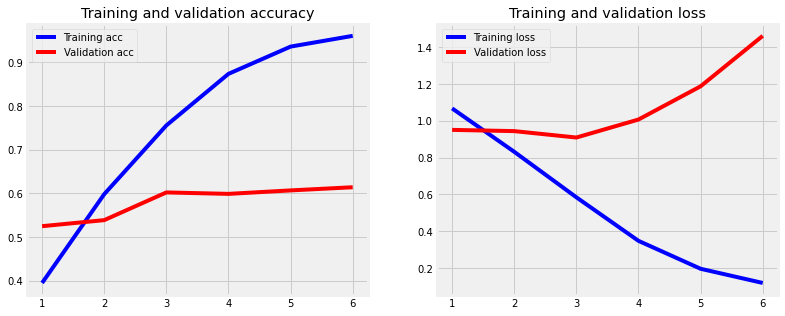

In [58]:
plot_history(history)

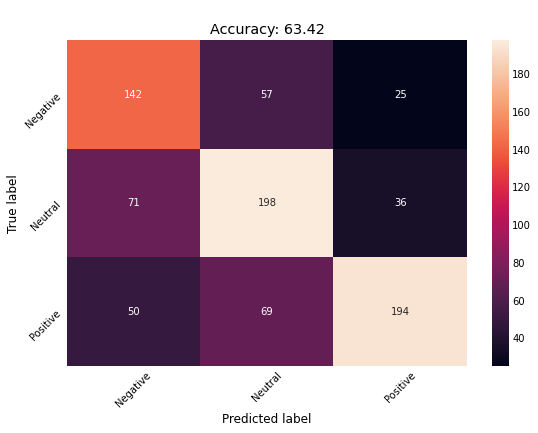

In [59]:
create_confusion_matrix(model_name)

In [60]:
generate_report(saved_model=model_name)

,precision,recall,f1-score,support
Negative,0.54,0.63,0.58,224.000000
Neutral,0.61,0.65,0.63,305.000000
Positive,0.76,0.62,0.68,313.000000
accuracy,0.63,0.63,0.63,0.634204
macro avg,0.64,0.63,0.63,842.000000
weighted avg,0.65,0.63,0.64,842.000000


# Model 2

In [85]:
model, callback_list, model_name = build_model(model_name="model2", embedding_dim=128, dropout_rate=0.5, units=[150, 60], patience=5)
history = fit_model(model=model, num_epochs=10, batch=32, callback_list=callback_list)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 128)           1825920   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 25, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 25, 150)           167400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                50640     
_________________________________________________________________
dense (Dense)                (None, 200)               12200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 2,056,763
Trainable params: 2,056,763
Non-trainable params: 0
______________________________________________

In [87]:
model = load_model(path + model_name + ".h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
print('Test Accuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred) * 100))

Test Accuracy: 60.10


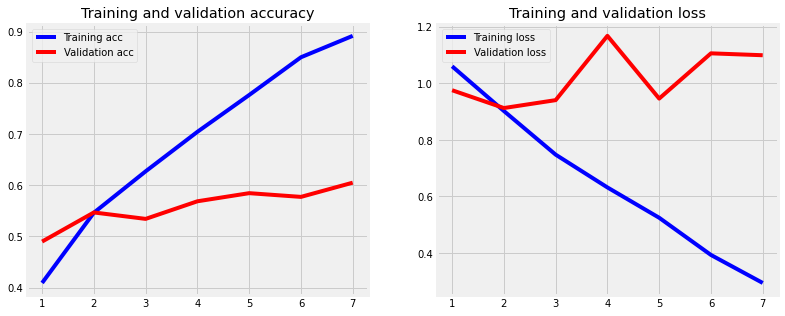

In [88]:
plot_history(history)

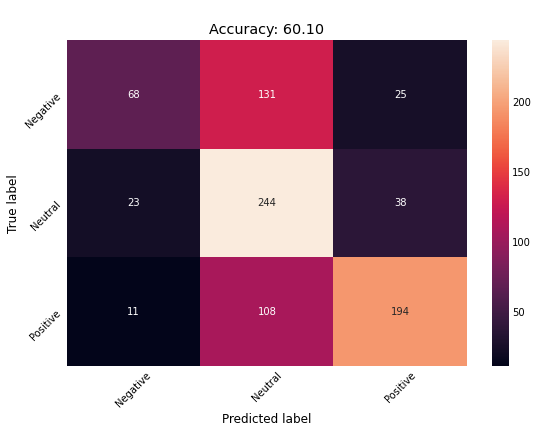

In [89]:
create_confusion_matrix(model_name)

In [90]:
generate_report(saved_model=model_name)

,precision,recall,f1-score,support
Negative,0.67,0.30,0.42,224.00000
Neutral,0.51,0.80,0.62,305.00000
Positive,0.75,0.62,0.68,313.00000
accuracy,0.60,0.60,0.60,0.60095
macro avg,0.64,0.57,0.57,842.00000
weighted avg,0.64,0.60,0.59,842.00000
